choose a good min_std threshold (sweep & inspect)

Systematically tests a range of min_std values to see how many ROIs would be kept.

It plots a raster plot per min_std for visualization.

basically we are evaluating the fucntion filter_inactive_rois_by_std_or_z
which Takes a ΔF/F matrix (T frames × N ROIs) and keeps ROIs that show either:
enough overall variability (std > min_std), or
enough “event” samples where the per-ROI z-score exceeds z_event.

## 1) Configuration (fixed percentile & window)

In [39]:
from pathlib import Path
from datetime import datetime

BASE_DIR = Path(r"C:\Users\suribear\OneDrive - Université de Lausanne\Lab\Data\2p")

EXPERIMENT_WHITELIST = [
    "L433_f02_Exp_1_flickering",
    "L433_f03_Exp_1_flickering",
    "L433_f04_Exp_1_flickering",
    "L433_f05_Exp_1_flickering",
    "L433_f06_Exp_1_flickering",
    "L453_f07_Exp_1_flickering",
    "L453_f08_Exp_1_flickering",
    "L453_f09_Exp_1_flickering",
    "L453_f10_Exp_1_flickering",
    "L453_f11_Exp_1_flickering",
    "L472_f01_Exp_2_rocking_1",
    "L472_f02_Exp_2_rocking_1",
    "L472_f03_Exp_2_rocking_1",
    "L472_f04_Exp_2_rocking_1",
]
PLANE_TO_EVAL = "plane1"

FPS_DEFAULT = 2.0
TAU_DEFAULT = 6.0

PERCENTILE_FIXED = 8
WINDOW_S_FIXED   = 40
INSTABILITY_RATIO = 0.1

MIN_STD_LIST = [0,  000.1] # put here the values

SESSION_TS = datetime.now().strftime("%Y%m%d_%H%M%S")
EVAL_ROOT = BASE_DIR / f"baseline_eval_minstd_only_{SESSION_TS}"
EVAL_ROOT.mkdir(parents=True, exist_ok=True)
print("Configured.")

Configured.


## 2) Imports & Helpers

In [40]:
import sys, io, traceback, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from contextlib import redirect_stdout, redirect_stderr
import importlib, src.dff_extraction as dff
importlib.reload(dff)

# sys.path.append(r"C:\\Users\\suribear\\code\\your_repo_root")  # if needed
try:
    from src.dff_extraction import process_suite2p_fluorescence
except Exception:
    print("Failed to import process_suite2p_fluorescence. Add your repo to sys.path above.")
    raise

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def find_experiments(base_dir: Path, whitelist=None):
    out = []
    for child in base_dir.iterdir():
        if child.is_dir():
            if whitelist and child.name not in whitelist:
                continue
            s2p = child / "03_analysis" / "functional" / "suite2P"
            if s2p.exists() and any(p.is_dir() and p.name.startswith("plane") for p in s2p.iterdir()):
                out.append(child)
    return sorted(out, key=lambda p: p.name)

def plane_dir(exp_dir: Path, plane_name: str):
    s2p = exp_dir / "03_analysis" / "functional" / "suite2P"
    p = s2p / plane_name
    return p if p.exists() else None

def experiment_prefix(exp_name: str) -> str:
    parts = exp_name.split("_")
    return parts[0] + "_" + parts[1] if len(parts) >= 2 else exp_name

def plot_raster_gray(dFoF, vmax=0.25, title=None, save_path: Path=None):
    peaks = np.nanmax(dFoF, axis=0)
    order = np.argsort(-peaks)
    dplot = dFoF[:, order]
    plt.figure(figsize=(10, 5))
    plt.imshow(np.clip(dplot, 0, vmax).T, aspect='auto', cmap='gray_r', vmin=0, vmax=vmax, interpolation='nearest')
    plt.xlabel('Time (frames)')
    plt.ylabel('ROIs (sorted by peak)')
    if title:
        plt.title(title)
    plt.colorbar(label=f'ΔF/F (clipped @ {vmax:.2f})')
    plt.tight_layout()
    if save_path is not None:
        ensure_dir(save_path.parent)
        plt.savefig(save_path, dpi=200)
    plt.show()
    return order, peaks

# ── Robust log parser ───────────────────────────────────────────────────────
_pat_excl_noncell   = re.compile(r"Excluded\s+(\\d+)\s+non-cell ROIs", re.I)
_pat_remaining_cells= re.compile(r"Remaining:\s*(\\d+)\s*cells?", re.I)
_pat_removed_dim    = re.compile(r"Removed\s+(\\d+)\s+dim ROIs", re.I)
_pat_removed_unst   = re.compile(r"Removed\s+(\\d+)\s+unstable ROIs", re.I)
_pat_final          = re.compile(r"Final ROIs:\s*(\\d+)", re.I)
_pat_final_alt      = re.compile(r"dF/?F0 computed\.\s*Final ROIs:\s*(\\d+)", re.I)
_pat_removed_compact= re.compile(r"Removed\s+(\\d+)\s*\\|\s*Remaining:\s*(\\d+)", re.I)

def parse_process_log(text: str):
    stats = {
        'excluded_noncell': None,
        'remaining_after_noncell': None,
        'removed_dim': None,
        'remaining_after_dim': None,
        'removed_unstable': None,
        'remaining_after_unstable': None,
        'final_rois': None,
        'initial_rois': None,
    }
    excl = [int(x) for x in _pat_excl_noncell.findall(text)]
    rems = [int(x) for x in _pat_remaining_cells.findall(text)]
    if excl:
        stats['excluded_noncell'] = excl[-1]
    if rems:
        stats['remaining_after_noncell'] = rems[-1]
    if stats['excluded_noncell'] is not None and stats['remaining_after_noncell'] is not None:
        stats['initial_rois'] = stats['excluded_noncell'] + stats['remaining_after_noncell']

    rdim = [int(x) for x in _pat_removed_dim.findall(text)]
    runst= [int(x) for x in _pat_removed_unst.findall(text)]
    if rdim:
        stats['removed_dim'] = rdim[-1]
        if stats['remaining_after_noncell'] is not None:
            stats['remaining_after_dim'] = stats['remaining_after_noncell'] - stats['removed_dim']
    if runst:
        stats['removed_unstable'] = runst[-1]
        if stats['remaining_after_dim'] is not None:
            stats['remaining_after_unstable'] = stats['remaining_after_dim'] - stats['removed_unstable']

    compact = [(int(a), int(b)) for a,b in _pat_removed_compact.findall(text)]
    if compact:
        if stats['removed_dim'] is None:
            stats['removed_dim'] = compact[0][0]
            stats['remaining_after_dim'] = compact[0][1]
        if len(compact) > 1 and stats['removed_unstable'] is None:
            stats['removed_unstable'] = compact[1][0]
            stats['remaining_after_unstable'] = compact[1][1]

    finals = [int(x) for x in (_pat_final.findall(text) + _pat_final_alt.findall(text))]
    if finals:
        stats['final_rois'] = finals[-1]
    return stats


## 3) Find Candidate Experiments

In [41]:
experiments = find_experiments(BASE_DIR, whitelist=EXPERIMENT_WHITELIST)
print(f"Found {len(experiments)} experiment folder(s).")
for e in experiments:
    print(' -', e.name)
if not experiments:
    raise RuntimeError('No experiments found. Check BASE_DIR or whitelist.')

Found 14 experiment folder(s).
 - L433_f02_Exp_1_flickering
 - L433_f03_Exp_1_flickering
 - L433_f04_Exp_1_flickering
 - L433_f05_Exp_1_flickering
 - L433_f06_Exp_1_flickering
 - L453_f07_Exp_1_flickering
 - L453_f08_Exp_1_flickering
 - L453_f09_Exp_1_flickering
 - L453_f10_Exp_1_flickering
 - L453_f11_Exp_1_flickering
 - L472_f01_Exp_2_rocking_1
 - L472_f02_Exp_2_rocking_1
 - L472_f03_Exp_2_rocking_1
 - L472_f04_Exp_2_rocking_1


## 4) Sweep MIN_STD only (capture stdout + stderr)


=== MIN_STD-only sweep for L433_f02_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

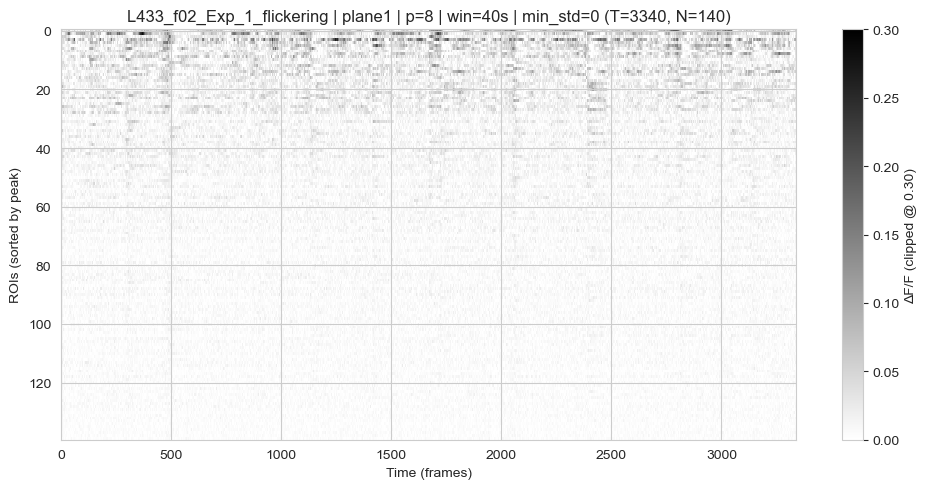

OK

=== MIN_STD-only sweep for L433_f03_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

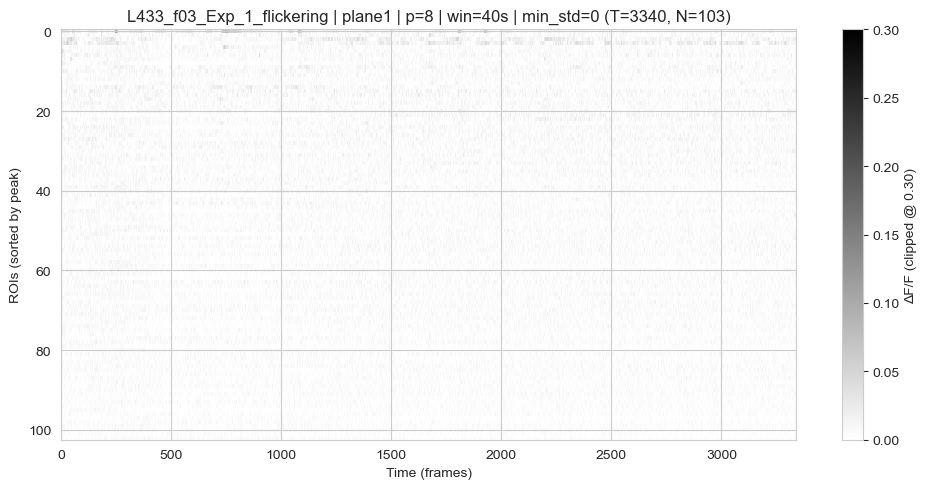

OK

=== MIN_STD-only sweep for L433_f04_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

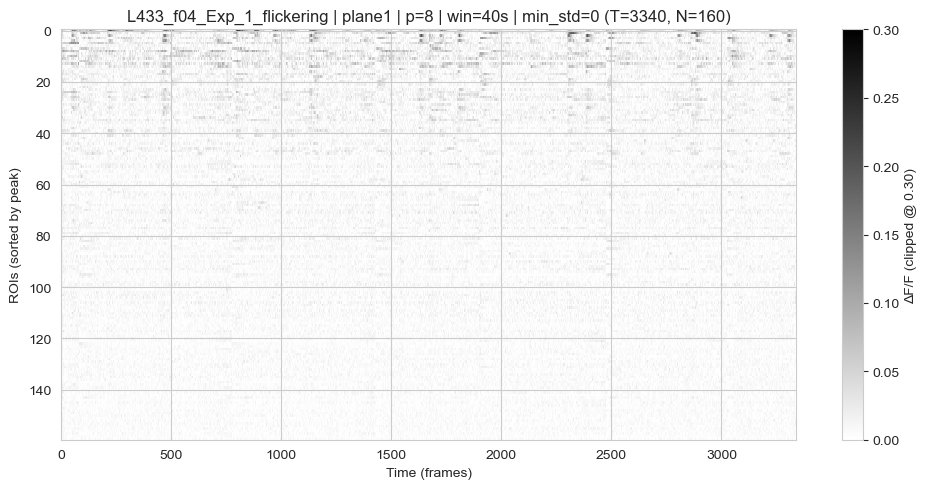

OK

=== MIN_STD-only sweep for L433_f05_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

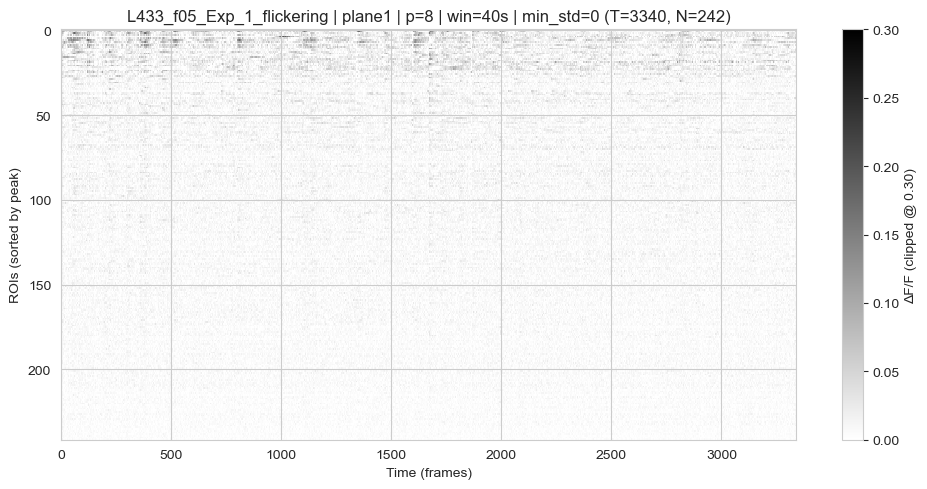

OK

=== MIN_STD-only sweep for L433_f06_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

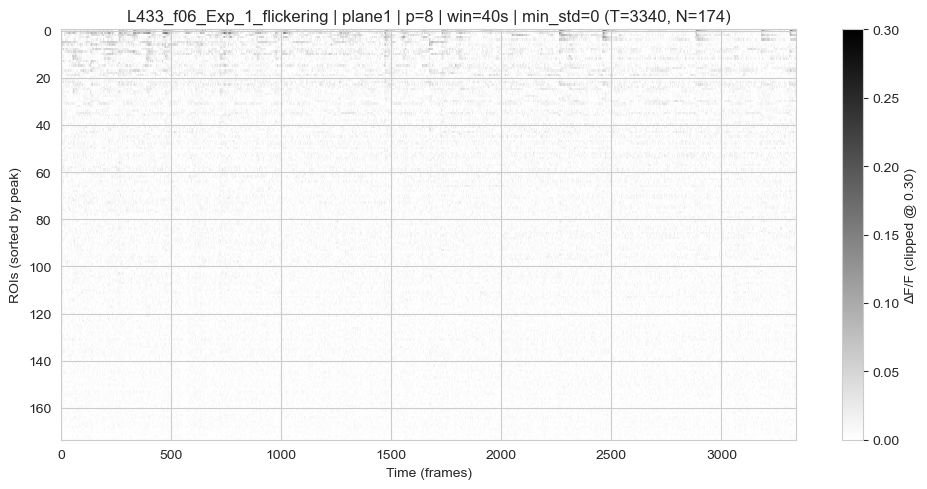

OK

=== MIN_STD-only sweep for L453_f07_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

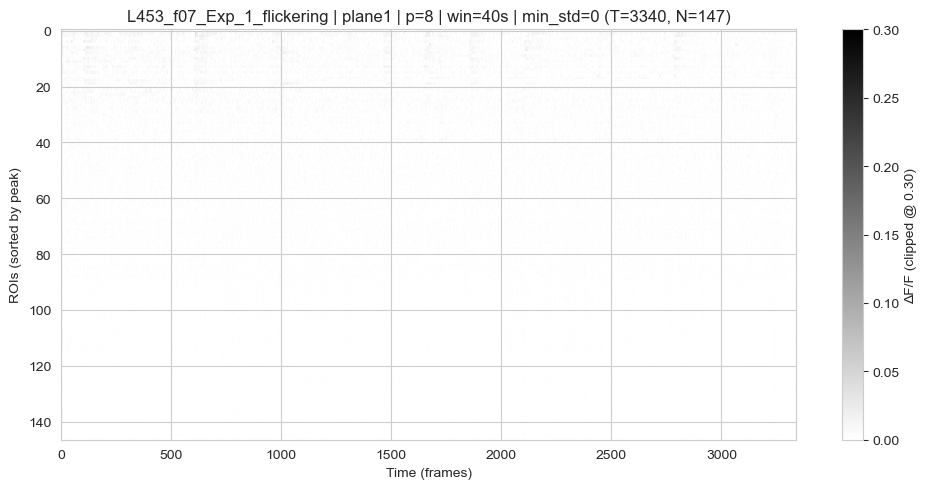

OK

=== MIN_STD-only sweep for L453_f08_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

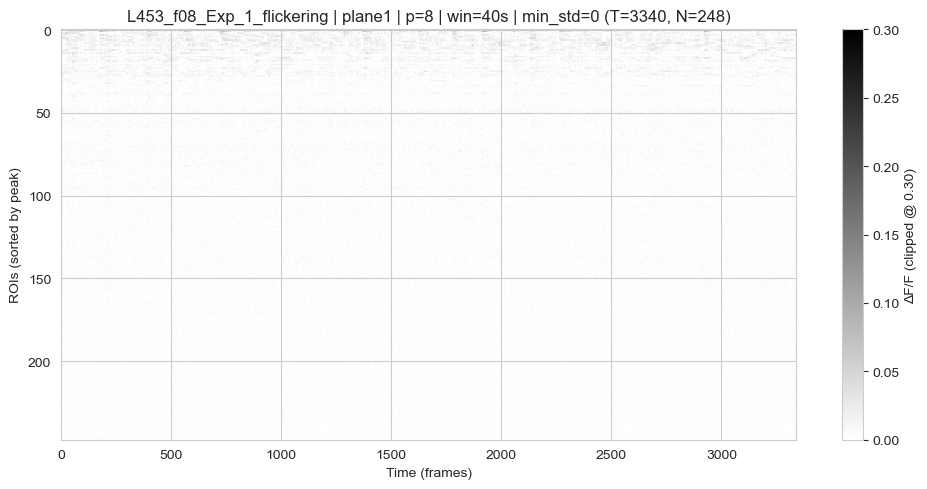

OK

=== MIN_STD-only sweep for L453_f09_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

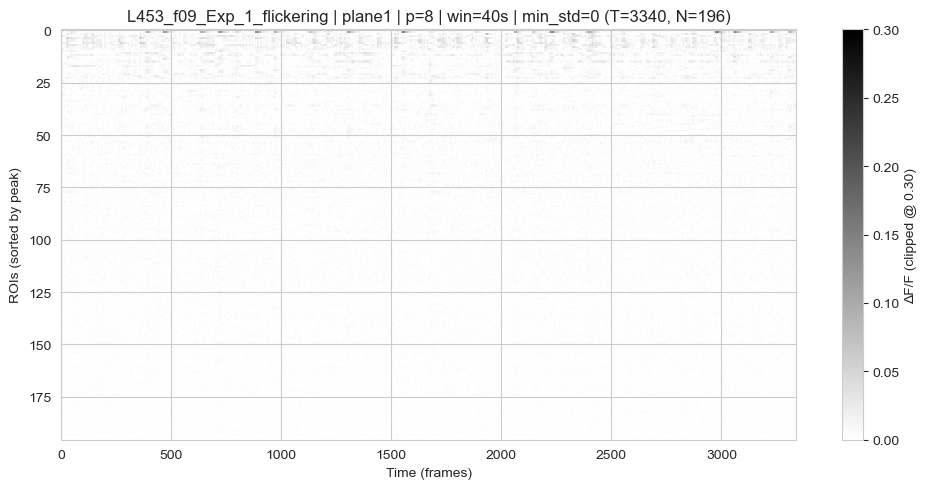

OK

=== MIN_STD-only sweep for L453_f10_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

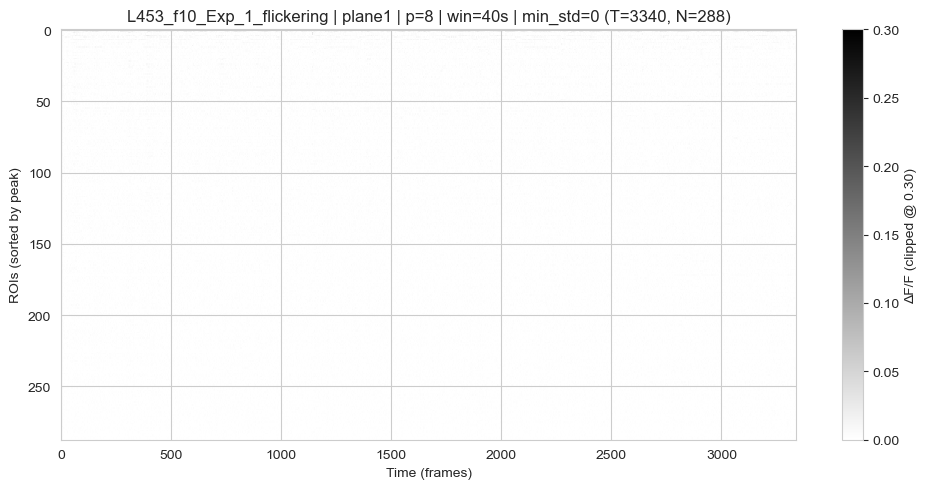

OK

=== MIN_STD-only sweep for L453_f11_Exp_1_flickering | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

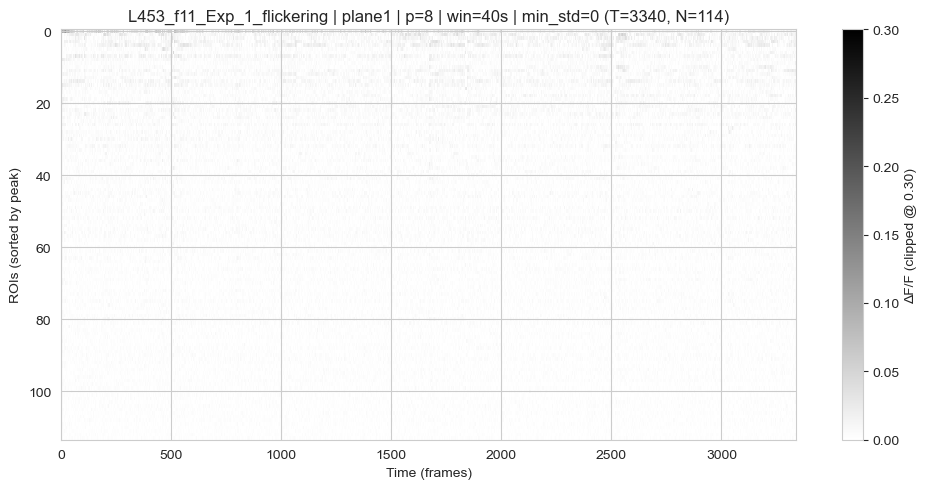

OK

=== MIN_STD-only sweep for L472_f01_Exp_2_rocking_1 | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

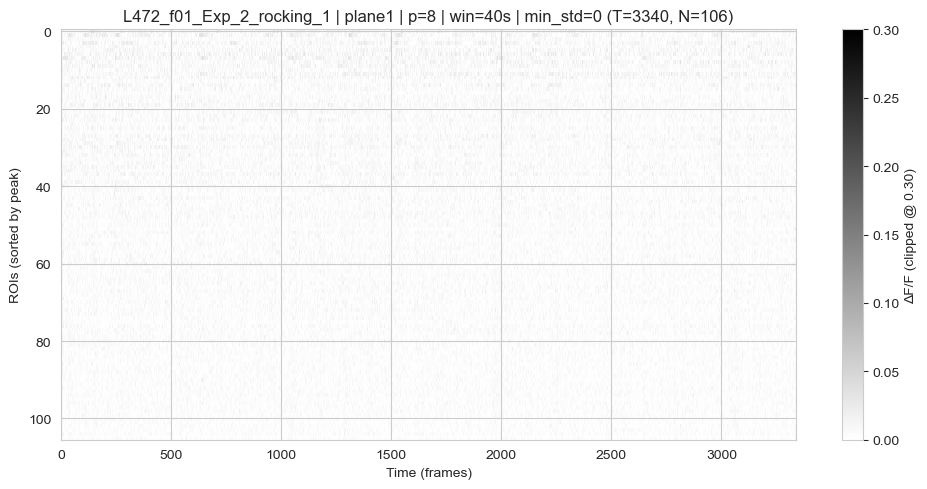

OK

=== MIN_STD-only sweep for L472_f02_Exp_2_rocking_1 | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

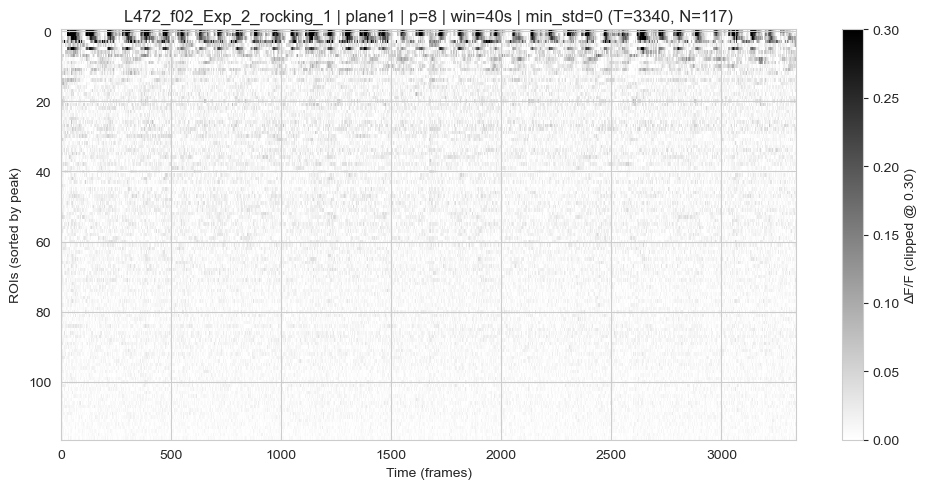

OK

=== MIN_STD-only sweep for L472_f03_Exp_2_rocking_1 | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

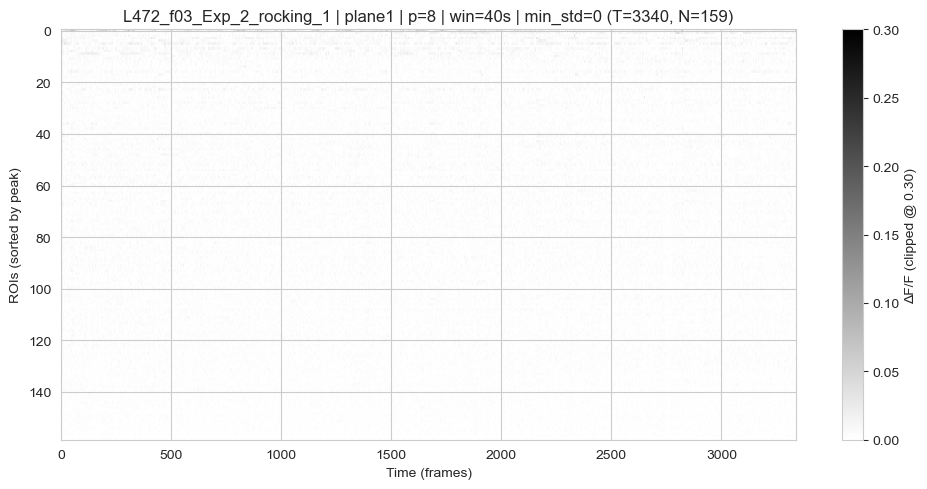

OK

=== MIN_STD-only sweep for L472_f04_Exp_2_rocking_1 | plane1 | p=8 | win=40s ===
  -> min_std=0 ... 

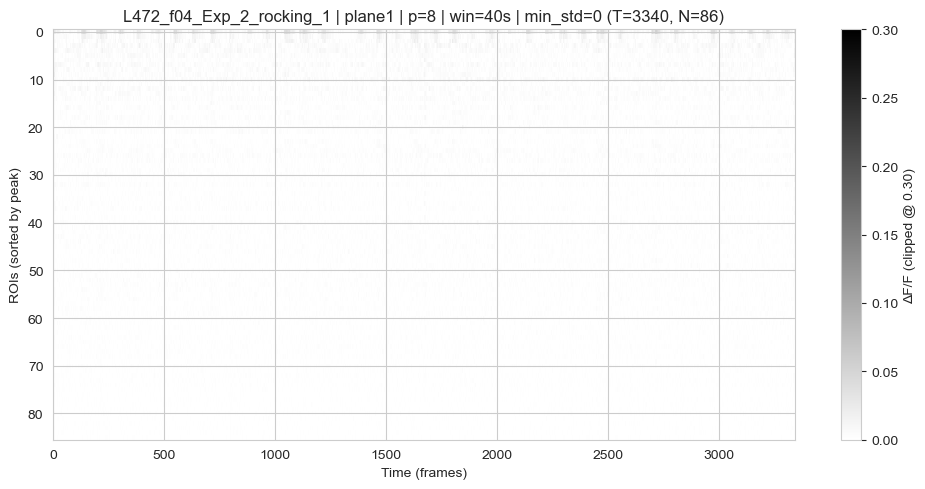

OK

Saved MIN_STD-only summary: C:\Users\suribear\OneDrive - Université de Lausanne\Lab\Data\2p\baseline_eval_minstd_only_20251028_154643\baseline_sweep_summary_minstd_only.csv


In [42]:
rows, fails = [], []
for exp_dir in experiments:
    exp_name = exp_dir.name
    pdir = plane_dir(exp_dir, PLANE_TO_EVAL)
    if pdir is None:
        print(f"[SKIP] {exp_name}: plane '{PLANE_TO_EVAL}' not found.")
        continue
    fps = float(FPS_DEFAULT)
    tau = float(TAU_DEFAULT)
    w_mult = max(1.0, WINDOW_S_FIXED / tau)
    out_base = EVAL_ROOT / exp_name / PLANE_TO_EVAL
    ensure_dir(out_base)
    print(f"\n=== MIN_STD-only sweep for {exp_name} | {PLANE_TO_EVAL} | p={PERCENTILE_FIXED} | win={WINDOW_S_FIXED}s ===")
    for min_std_val in MIN_STD_LIST:
        try:
            print(f"  -> min_std={min_std_val:g} ... ", end="")
            buf_out, buf_err = io.StringIO(), io.StringIO()
            with redirect_stdout(buf_out), redirect_stderr(buf_err):
                dFoF, filtered_indices = process_suite2p_fluorescence(
                    f_path=pdir,
                    fps=fps,
                    tau=tau,
                    percentile=PERCENTILE_FIXED,
                    instability_ratio=INSTABILITY_RATIO,
                    min_window_s=WINDOW_S_FIXED,
                    window_tau_multiplier=w_mult,
                    min_std=min_std_val,
                )
            logtxt = (buf_out.getvalue() + "\n" + buf_err.getvalue())

            T, N = dFoF.shape
            png_tag = str(min_std_val).replace('.', 'p')
            raster_png = out_base / f"{experiment_prefix(exp_name)}_{PLANE_TO_EVAL}_raster_p{PERCENTILE_FIXED}_w{WINDOW_S_FIXED}_m{png_tag}.png"
            title = f"{exp_name} | {PLANE_TO_EVAL} | p={PERCENTILE_FIXED} | win={WINDOW_S_FIXED}s | min_std={min_std_val} (T={T}, N={N})"
            order, peaks = plot_raster_gray(dFoF, vmax=0.3, title=title, save_path=raster_png)

            stats = parse_process_log(logtxt)
            excl_noncell = stats.get('excluded_noncell') or 0
            removed_dim = stats.get('removed_dim') or 0
            removed_unstable = stats.get('removed_unstable') or 0
            final_rois = stats.get('final_rois') or int(N)

            rem_after_noncell = stats.get('remaining_after_noncell')
            rem_after_dim = stats.get('remaining_after_dim')
            rem_after_unstable = stats.get('remaining_after_unstable')
            if rem_after_noncell is None and stats.get('initial_rois') is not None:
                rem_after_noncell = stats['initial_rois'] - excl_noncell
            if rem_after_dim is None and rem_after_noncell is not None:
                rem_after_dim = rem_after_noncell - removed_dim
            if rem_after_unstable is None and rem_after_dim is not None:
                rem_after_unstable = rem_after_dim - removed_unstable

            rows.append({
                'experiment': exp_name,
                'plane': PLANE_TO_EVAL,
                'percentile': PERCENTILE_FIXED,
                'window_s': WINDOW_S_FIXED,
                'min_std': float(min_std_val),
                'T': int(T),
                'N_final': int(final_rois),
                'excluded_noncell': int(excl_noncell),
                'removed_dim': int(removed_dim),
                'removed_unstable': int(removed_unstable),
                'remaining_after_noncell': None if rem_after_noncell is None else int(rem_after_noncell),
                'remaining_after_dim': None if rem_after_dim is None else int(rem_after_dim),
                'remaining_after_unstable': None if rem_after_unstable is None else int(rem_after_unstable),
                'raster_path': str(raster_png),
                'log_excerpt': "\n".join(logtxt.strip().splitlines()[-6:]),
            })
            print("OK")
        except Exception as ex:
            print("ERROR")
            fails.append((exp_name, PLANE_TO_EVAL, min_std_val, repr(ex)))
            traceback.print_exc()

SUMMARY_CSV = EVAL_ROOT / 'baseline_sweep_summary_minstd_only.csv'
if rows:
    df = pd.DataFrame(rows).sort_values(['experiment','plane','min_std'])
    df.to_csv(SUMMARY_CSV, index=False, encoding='utf-8')
    print(f"\nSaved MIN_STD-only summary: {SUMMARY_CSV}")
else:
    print("\nNo successful MIN_STD runs to summarize.")
if fails:
    print('\nFailures:')
    for f in fails:
        print('  ', f)

## 5) Quick view

In [ ]:
try:
    df_check = pd.read_csv(SUMMARY_CSV)
    print(df_check[["experiment","plane","min_std","N_final","excluded_noncell","removed_dim","removed_unstable"]]
          .sort_values(["experiment","plane","min_std"]))
except Exception:
    print("Run the sweep first to create the summary.")

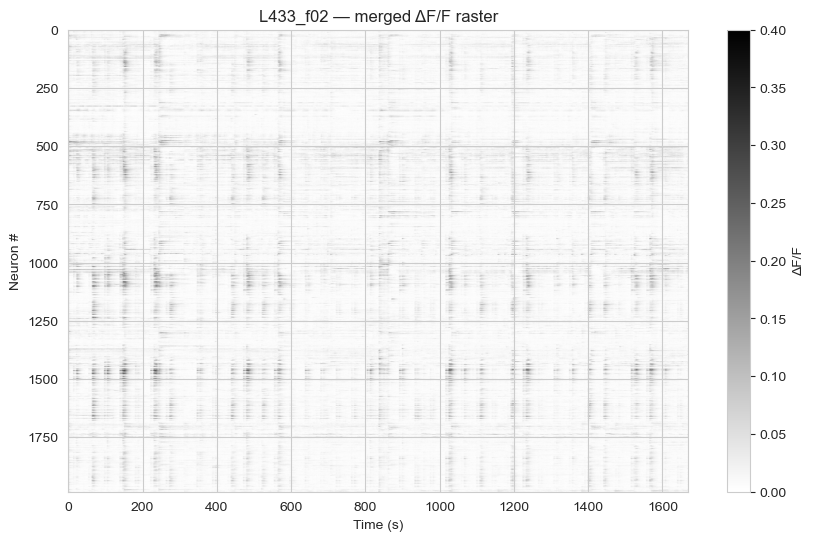

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def simple_raster_plot(dff_path, fps=2.0, vmin=0, vmax=0.4, title="ΔF/F Raster"):
    """
    Load ΔF/F (deltaF_F) data from a .npy or .mat file and plot a grayscale raster.

    Parameters:
    - dff_path: path to file containing ΔF/F array (T x N)
                (.npy with shape (frames, neurons) or .mat with 'deltaFoF')
    - fps: frames per second, used to create time axis (default=2.0)
    - vmin, vmax: limits for grayscale normalization
    - title: title for the plot
    """

    dff_path = Path(dff_path)
    if not dff_path.exists():
        raise FileNotFoundError(f"File not found: {dff_path}")

    # --- Load ΔF/F data ---
    if dff_path.suffix == ".npy":
        deltaF_F = np.load(dff_path)
    elif dff_path.suffix == ".mat":
        from scipy.io import loadmat
        data = loadmat(dff_path)
        if "deltaFoF" in data:
            deltaF_F = data["deltaFoF"]
        else:
            raise KeyError("Expected 'deltaFoF' variable in .mat file.")
    else:
        raise ValueError("Unsupported file type. Use .npy or .mat")

    # --- Plot raster ---
    time_axis = np.arange(deltaF_F.shape[0]) / fps
    plt.figure(figsize=(10, 6))
    plt.imshow(
        deltaF_F.T,
        aspect='auto',
        cmap='gray_r',
        vmin=vmin,
        vmax=vmax,
        extent=[time_axis[0], time_axis[-1], deltaF_F.shape[1], 0]
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron #")
    plt.title(title)
    plt.colorbar(label="ΔF/F")
    plt.show()


path = Path(r"C:\Users\suribear\OneDrive - Université de Lausanne\Lab\Data\2p\L433_f02_Exp_1_flickering\03_analysis\functional\suite2P\merged_dFoF\L433_f02_dFoF_merged.npy")

# Call the function
simple_raster_plot(
    dff_path=path,
    fps=2.0,           # imaging rate (Hz)
    vmin=0.0,          # grayscale min
    vmax=0.4,          # grayscale max
    title="L433_f02 — merged ΔF/F raster"
)

